In [1]:
import numba
from numba import cuda
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import math

In [2]:
img = plt.imread('frog.jpg')

width, height = img.shape[0], img.shape[1]
PixCount = img.shape[0]* img.shape[1]

img = img.astype('float64')

In [3]:
@cuda.jit
def RGB_to_HSV(input, output):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  R = input[tidx, tidy, 0] / 255
  G = input[tidx, tidy, 1] / 255
  B = input[tidx, tidy, 1] / 255

  maxRGB = max(R,G,B)
  minRGB = min(R,G,B)
  delta = maxRGB - minRGB

  if delta == 0:
    output[tidx, tidy, 0] = 0
  elif R == maxRGB :
    output[tidx, tidy, 0] = 60 * (((G - B)/delta)%6)
  elif G == maxRGB :
    output[tidx, tidy, 0] = 60 * ((B-R)/delta + 2)
  elif B == maxRGB :
    output[tidx, tidy, 0] = 60 * ((R-G)/delta + 4)

  if maxRGB != 0:
    output[tidx, tidy, 1] = delta / maxRGB
  else:
    output[tidx, tidy, 1] = 0

  output[tidx, tidy, 2] = maxRGB

In [49]:
def Kuwahara_filter_CPU(image_RGB, image_HSV, window_size):
  height, width, channels = image_RGB.shape
  output_image = np.zeros((height, width, channels), dtype=np.uint8)
  half_window = window_size // 2

  for y in range(half_window, height - half_window):
    for x in range(half_window, width - half_window):
      subregions = []
      window_sd = []
      min_sd_index = 0

      for i in range(4):
        if i == 0:
            subregion = image_HSV[y - half_window:y, x - half_window:x, 2]
        elif i == 1:
            subregion = image_HSV[y - half_window:y, x:x + half_window, 2]
        elif i == 2:
            subregion = image_HSV[y:y + half_window, x - half_window:x, 2]
        else:
            subregion = image_HSV[y:y + half_window, x:x + half_window, 2]
        subregions.append(subregion)
        window_sd.append(np.std(subregion))

        min_sd_index = np.argmin(window_sd)

      if min_sd_index == 0:
        output_image[y, x, 0] = np.mean(image_RGB[y - half_window:y, x - half_window:x, 0])
        output_image[y, x, 1] = np.mean(image_RGB[y - half_window:y, x - half_window:x, 1])
        output_image[y, x, 2] = np.mean(image_RGB[y - half_window:y, x - half_window:x, 2])
      elif min_sd_index == 1:
        output_image[y, x, 0] = np.mean(image_RGB[y - half_window:y, x:x + half_window, 0])
        output_image[y, x, 1] = np.mean(image_RGB[y - half_window:y, x:x + half_window, 1])
        output_image[y, x, 2] = np.mean(image_RGB[y - half_window:y, x:x + half_window, 2])
      elif min_sd_index == 2:
        output_image[y, x, 0] = np.mean(image_RGB[y:y + half_window, x - half_window:x, 0])
        output_image[y, x, 1] = np.mean(image_RGB[y:y + half_window, x - half_window:x, 1])
        output_image[y, x, 2] = np.mean(image_RGB[y:y + half_window, x - half_window:x, 2])
      else:
        output_image[y, x, 0] = np.mean(image_RGB[y:y + half_window, x:x + half_window, 0])
        output_image[y, x, 1] = np.mean(image_RGB[y:y + half_window, x:x + half_window, 1])
        output_image[y, x, 2] = np.mean(image_RGB[y:y + half_window, x:x + half_window, 2])

  return output_image


In [47]:
@cuda.jit
def Kuwahara_filter_GPU(input, output, HSV, window_size):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  half_window = window_size // 2

  if tidx < half_window or tidx >= input.shape[0] - half_window or tidy < half_window or tidy >= input.shape[1] - half_window:
        output[tidx, tidy, 0] = output[tidx, tidy, 1] = output[tidx, tidy, 2] = 0
        return

  sd1, sd2, sd3, sd4 = 0.0, 0.0, 0.0, 0.0
  sum, sum1, sum2, sum3, sum4 = 0.0, 0.0, 0.0, 0.0, 0.0
  mean1, mean2, mean3, mean4 = 0.0, 0.0, 0.0, 0.0
  #Calcul SD part 1
  for y in range(tidy - half_window, tidy):
    for x in range(tidx - half_window, tidx):
      sum += HSV[y, x, 2]
  mean1 = sum / (half_window ** 2)
  for y in range(tidy - half_window, tidy):
    for x in range(tidx - half_window, tidx):
      sum1 = sum1 + ((HSV[y, x, 2] - mean1) ** 2)
  sd1 = math.sqrt(sum1 / (half_window ** 2))
  sum = 0
  #Calcul SD part 2
  for y in range(tidy - half_window, tidy):
    for x in range(tidx, tidx + half_window):
      sum += HSV[y, x, 2]
  mean2 = sum / (half_window ** 2)
  for y in range(tidy - half_window, tidy):
    for x in range(tidx, tidx + half_window):
      sum2 = sum2 + ((HSV[y, x, 2] - mean2) ** 2)
  sd2 = math.sqrt(sum2 / (half_window ** 2))
  sum = 0
  #Calcul SD part 3
  for y in range(tidy, tidy + half_window):
    for x in range(tidx - half_window, tidx):
      sum += HSV[y, x, 2]
  mean3 = sum / (half_window ** 2)
  for y in range(tidy, tidy + half_window):
    for x in range(tidx - half_window, tidx):
      sum3 = sum3 + ((HSV[y, x, 2] - mean3) ** 2)
  sd3 = math.sqrt(sum3 / (half_window ** 2))
  sum = 0
  #Calcul SD part 4
  for y in range(tidy, tidy + half_window):
    for x in range(tidx, tidx + half_window):
      sum += HSV[y, x, 2]
  mean4 = sum / (half_window ** 2)
  for y in range(tidy, tidy + half_window):
    for x in range(tidx, tidx + half_window):
      sum4 = sum4 + ((HSV[y, x, 2] - mean4) ** 2)
  sd4 = math.sqrt(sum4 / (half_window ** 2))


  min_sd_index = min(sd1, sd2, sd3, sd4)

  R, G, B = 0, 0, 0

  if min_sd_index == 0:
    for y in range(tidy - half_window, tidy):
      for x in range(tidx - half_window, tidx):
        R += input[y, x, 0]
        G += input[y, x, 1]
        B += input[y, x, 2]
  elif min_sd_index == 1:
    for y in range(tidy - half_window, tidy):
      for x in range(tidx, tidx + half_window):
        R += input[y, x, 0]
        G += input[y, x, 1]
        B += input[y, x, 2]
  elif min_sd_index == 2:
    for y in range(tidy, tidy + half_window):
      for x in range(tidx - half_window, tidx):
        R += input[y, x, 0]
        G += input[y, x, 1]
        B += input[y, x, 2]
  else:
    for y in range(tidy, tidy + half_window):
      for x in range(tidx, tidx + half_window):
        R += input[y, x, 0]
        G += input[y, x, 1]
        B += input[y, x, 2]

  output[tidy, tidx, 0] = R // (half_window ** 2)
  output[tidy, tidx, 1] = G // (half_window ** 2)
  output[tidy, tidx, 2] = B // (half_window ** 2)

Time taken for the CPU to implement the filter :  109.93167781829834 s.
Time taken for the GPU to implement the filter :  0.12260794639587402 s.


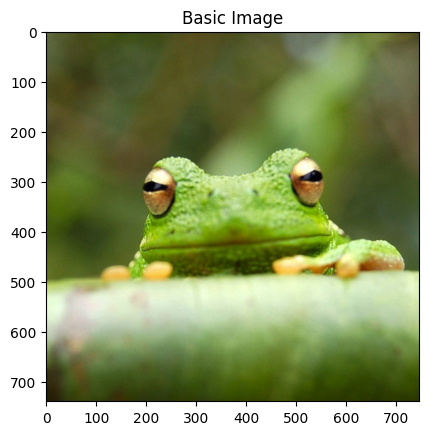

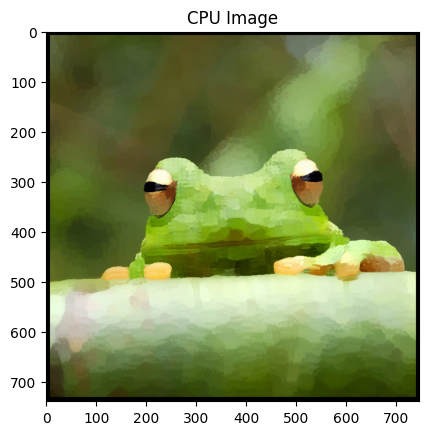

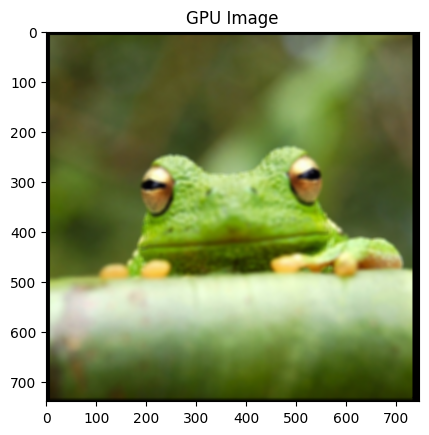

In [52]:
#Part Converting Image RGB to HSV
blockSize = (2, 2)
gridSize = (math.ceil(width/blockSize[0]), math.ceil(height/blockSize[1]))
devInput = cuda.to_device(img)
devOutput = cuda.device_array((width, height, 3), np.float64)
RGB_to_HSV[gridSize, blockSize](devInput, devOutput)
imgHSV = devOutput.copy_to_host()

startCPU = time.time()

final_img = Kuwahara_filter_CPU(img, imgHSV, 16)

endCPU = time.time()

startGPU = time.time()

devOutput2 = cuda.device_array((width, height, 3), np.uint8)
Kuwahara_filter_GPU[gridSize, blockSize](devInput, devOutput2, devOutput, 16)
final_img2 = devOutput2.copy_to_host()

endGPU = time.time()

print("Time taken for the CPU to implement the filter : ", endCPU - startCPU, "s.")
print("Time taken for the GPU to implement the filter : ", endGPU - startGPU, "s.")

plt.imshow(img.astype('uint8'))
plt.title('Basic Image')
plt.show()

plt.imshow(final_img)
plt.title('CPU Image')
plt.show()

plt.imshow(final_img2)
plt.title('GPU Image')
plt.show()